### Warper model to pick either GRU or LSTM at each day

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV #cross_valid
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
import datetime
from scipy.spatial import distance
from numba import jit
from scipy.stats import norm
import collections
import pandas.io.sql as sqlio
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix

import seaborn as sns
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
df = pd.read_csv('avg_infected_obs_all_pred_Nov20.csv')
print(df.shape)
df.head()

(660, 10)


,Date,Observed_cases,Pred_GRU_1,Pred_GRU_2,Pred_GRU_3,Pred_mean_GRU,Pred_LSTM_1,Pred_LSTM_2,Pred_LSTM_3,Pred_mean_LSTM
0,2020-01-31,0,0,0,0,0,0,1,1,1
1,2020-02-01,0,5,5,2,4,3,2,3,3
2,2020-02-02,0,0,0,0,0,0,1,0,0
3,2020-02-03,0,1,3,2,2,0,1,1,1
4,2020-02-04,1,0,0,1,0,0,1,1,1


#### 0 LSTM
#### 1 GRU

In [3]:
def lstm_or_gru(obs,lstm,gru):
    lstm_err = abs(obs - lstm) #absolute err
    gru_err = abs(obs - gru)
    if(lstm_err < gru_err): return 0 # lstm
    else: return 1 # gru

In [4]:
res = [] # 0 or 1
for index, row in df.iterrows():
    res.append(lstm_or_gru(row['Observed_cases'], row['Pred_mean_LSTM'], row['Pred_mean_GRU']))
df['Y'] = res

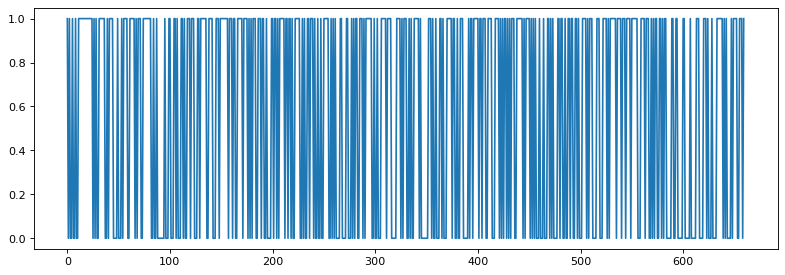

In [5]:
from matplotlib.pyplot import figure
figure(figsize=(12, 4), dpi=80)
plt.plot(res)


(array([290.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 370.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

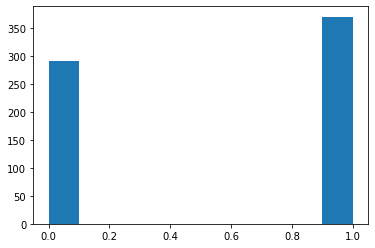

In [6]:
plt.hist(res)

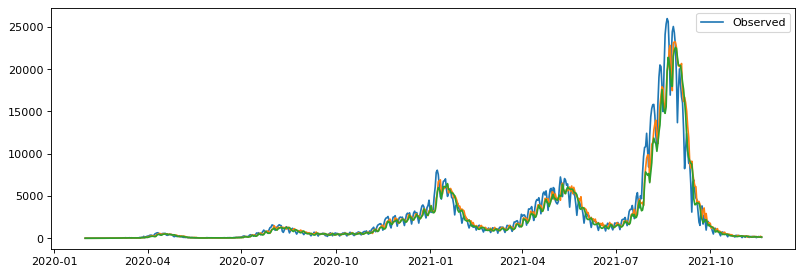

In [7]:
from matplotlib.pyplot import figure
figure(figsize=(12, 4), dpi=80)
time = pd.to_datetime(df['Date'])
plt.plot(time,df['Observed_cases'], label='Observed')
plt.plot(time,df['Pred_mean_GRU'])
plt.plot(time,df['Pred_mean_LSTM'])
plt.legend()

In [8]:
split_point = int(len(df)*7/10)
split_point

462

In [9]:
df.head()

,Date,Observed_cases,Pred_GRU_1,Pred_GRU_2,Pred_GRU_3,Pred_mean_GRU,Pred_LSTM_1,Pred_LSTM_2,Pred_LSTM_3,Pred_mean_LSTM,Y
0,2020-01-31,0,0,0,0,0,0,1,1,1,1
1,2020-02-01,0,5,5,2,4,3,2,3,3,0
2,2020-02-02,0,0,0,0,0,0,1,0,0,1
3,2020-02-03,0,1,3,2,2,0,1,1,1,0
4,2020-02-04,1,0,0,1,0,0,1,1,1,0


In [10]:
X = df[['Pred_mean_GRU', 'Pred_mean_LSTM']]
Y = df['Y']
print(X.shape, Y.shape)

(660, 2) (660,)


In [11]:
X

,Pred_mean_GRU,Pred_mean_LSTM
0,0,1
1,4,3
2,0,0
3,2,1
4,0,1
...,...,...
655,147,147
656,172,140
657,160,134
658,237,135


In [12]:
X_train = X[:split_point]
y_train = Y[:split_point]

X_val = X[split_point:]
y_val = Y[split_point:]
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(462, 2) (462,)
(198, 2) (198,)


In [13]:
# binary classifying
clf_xbg = xgb.XGBClassifier(objective='binary:logistic')
train_process = clf_xbg.fit(X_train, y_train, verbose=True, early_stopping_rounds=200,
                            eval_metric='auc', eval_set=[(X_val, y_val)])

[0]	validation_0-auc:0.49013
[1]	validation_0-auc:0.53355
[2]	validation_0-auc:0.56189
[3]	validation_0-auc:0.55406
[4]	validation_0-auc:0.58332
[5]	validation_0-auc:0.59273
[6]	validation_0-auc:0.58015
[7]	validation_0-auc:0.57754
[8]	validation_0-auc:0.56720
[9]	validation_0-auc:0.56925
[10]	validation_0-auc:0.57396
[11]	validation_0-auc:0.57396
[12]	validation_0-auc:0.58009
[13]	validation_0-auc:0.58812
[14]	validation_0-auc:0.60081
[15]	validation_0-auc:0.60510
[16]	validation_0-auc:0.60137
[17]	validation_0-auc:0.60434
[18]	validation_0-auc:0.60434
[19]	validation_0-auc:0.60275
[20]	validation_0-auc:0.60940
[21]	validation_0-auc:0.60418
[22]	validation_0-auc:0.60060
[23]	validation_0-auc:0.60060
[24]	validation_0-auc:0.59707
[25]	validation_0-auc:0.59452
[26]	validation_0-auc:0.59452
[27]	validation_0-auc:0.59810
[28]	validation_0-auc:0.59810
[29]	validation_0-auc:0.59319
[30]	validation_0-auc:0.59615
[31]	validation_0-auc:0.60035
[32]	validation_0-auc:0.60122
[33]	validation_0-au

C:\Users\maidu\.conda\envs\tf\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[58]	validation_0-auc:0.58081
[59]	validation_0-auc:0.57938
[60]	validation_0-auc:0.58792
[61]	validation_0-auc:0.58649
[62]	validation_0-auc:0.58649
[63]	validation_0-auc:0.58557
[64]	validation_0-auc:0.58618
[65]	validation_0-auc:0.58618
[66]	validation_0-auc:0.58332
[67]	validation_0-auc:0.58332
[68]	validation_0-auc:0.58209
[69]	validation_0-auc:0.58229
[70]	validation_0-auc:0.58874
[71]	validation_0-auc:0.58332
[72]	validation_0-auc:0.58332
[73]	validation_0-auc:0.57871
[74]	validation_0-auc:0.57718
[75]	validation_0-auc:0.57631
[76]	validation_0-auc:0.57201
[77]	validation_0-auc:0.56823
[78]	validation_0-auc:0.56363
[79]	validation_0-auc:0.56516
[80]	validation_0-auc:0.56485
[81]	validation_0-auc:0.56506
[82]	validation_0-auc:0.57365
[83]	validation_0-auc:0.56649
[84]	validation_0-auc:0.56925
[85]	validation_0-auc:0.57293
[86]	validation_0-auc:0.56629
[87]	validation_0-auc:0.56629
[88]	validation_0-auc:0.56629
[89]	validation_0-auc:0.56629
[90]	validation_0-auc:0.56639
[91]	valid

In [14]:
y_pred = clf_xbg.predict(X_val)

<AxesSubplot:>

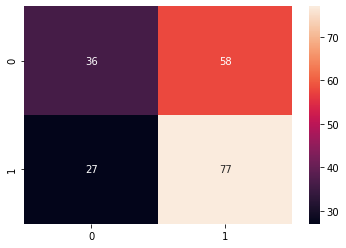

In [15]:
cf_matrix = confusion_matrix(y_val, y_pred)
sns.heatmap(cf_matrix, annot=True)

C:\Users\maidu\.conda\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


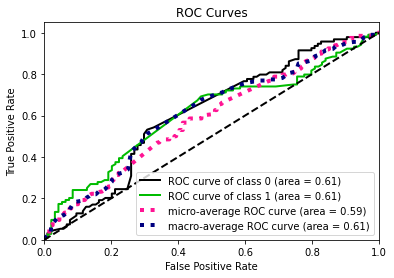

In [16]:
import scikitplot as skplt
import matplotlib.pyplot as plt


y_probas = clf_xbg.predict_proba(X_val)# predicted probabilities generated by sklearn classifier
skplt.metrics.plot_roc_curve(y_val, y_probas)
plt.show()

In [17]:
clf_xbg.save_model('xgb_lstm_gru_mean_Nov21.json')

In [18]:
# remove after use

In [19]:
df_pred_old = pd.read_csv('y_pred_gru_lstm_avg.csv')
df_pred_old

,Date,Observed_cases,Pred_GRU_1,Pred_GRU_2,Pred_GRU_3,Pred_mean_GRU,Pred_LSTM_1,Pred_LSTM_2,Pred_LSTM_3,Pred_mean_LSTM
0,2020-04-06,353,818,473,1179,823,199,398,1171,589
1,2020-04-07,365,908,525,1134,856,226,429,1199,618
2,2020-04-08,346,812,521,1103,812,256,448,1206,637
3,2020-04-09,248,802,542,1133,826,290,462,1202,651
4,2020-04-10,365,828,536,1111,825,322,456,1154,644
...,...,...,...,...,...,...,...,...,...,...
561,2021-10-19,502,1041,783,1206,1010,677,668,1219,855
562,2021-10-20,425,867,677,1055,866,655,558,1185,799
563,2021-10-21,223,810,697,1250,919,608,555,1228,797
564,2021-10-22,367,881,729,1280,963,540,566,1173,760


## Comparing prediction result with scaling problem

In [20]:
time_pred_old = pd.to_datetime(df_pred_old['Date'])

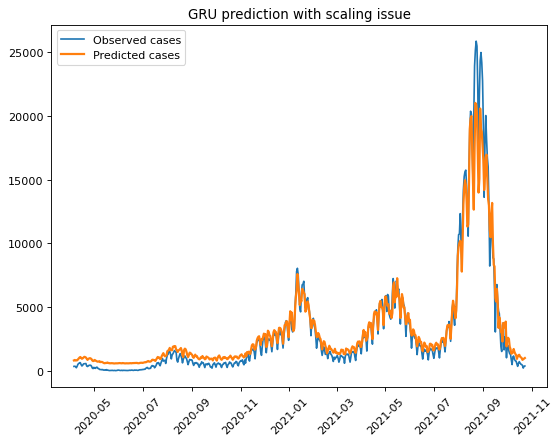

In [21]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)

plt.plot(time_pred_old,df_pred_old['Observed_cases'], label='Observed cases')
plt.plot(time_pred_old,df_pred_old['Pred_mean_GRU'], label='Predicted cases', linewidth=2)
plt.title('GRU prediction with scaling issue')
plt.xticks(rotation=45)


plt.legend()

In [22]:
#new

In [23]:
time_new = pd.to_datetime(df['Date'])[66:]

In [24]:
time_new

66    2020-04-06
67    2020-04-07
68    2020-04-08
69    2020-04-09
70    2020-04-10
         ...    
655   2021-11-16
656   2021-11-17
657   2021-11-18
658   2021-11-19
659   2021-11-20
Name: Date, Length: 594, dtype: datetime64[ns]

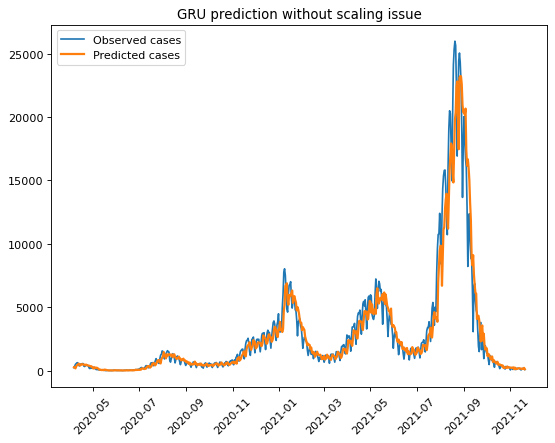

In [25]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)

plt.plot(time_new,df['Observed_cases'][66:], label='Observed cases')
plt.plot(time_new,df['Pred_mean_GRU'][66:], label='Predicted cases', linewidth=2)
plt.xticks(rotation=45)
plt.title('GRU prediction without scaling issue')

plt.legend()